# Multi-Objective Capacitated VRP (MOVRP) Problem Using Multi-Objective Evolutionary Algorithms (MOEAs)

### Global Functions

In [1]:
import math
import numpy as np

def parse_vrp_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Strip whitespace and filter empty lines
    lines = [line.strip() for line in lines if line.strip()]

    # Parse metadata
    metadata = {}
    i = 0
    while not lines[i].startswith('NODE_COORD_SECTION'):
        if ':' in lines[i]:
            key, value = lines[i].split(':', 1)
            metadata[key.strip()] = value.strip().strip('"')
        i += 1

    # Parse node coordinates (1-based in file, but we'll make 0-based list)
    coords = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEMAND_SECTION'):
        parts = lines[i].split()
        if len(parts) == 3:
            node_id = int(parts[0]) - 1  # Make 0-based
            x, y = int(parts[1]), int(parts[2])
            # Insert at correct index in case not sequential (though they usually are)
            while len(coords) <= node_id:
                coords.append(None)
            coords[node_id] = (x, y)
        i += 1

    # Parse demands (0-based list)
    demands = []
    i += 1  # Skip section header
    while not lines[i].startswith('DEPOT_SECTION'):
        parts = lines[i].split()
        if len(parts) == 2:
            node_id = int(parts[0]) - 1  # Make 0-based
            demand = int(parts[1])
            while len(demands) <= node_id:
                demands.append(None)
            demands[node_id] = demand
        i += 1

    # Parse depot(s) — usually just one, 1-based
    depots = []
    i += 1  # Skip section header
    while i < len(lines) and lines[i] != 'EOF':
        depot = int(lines[i])
        if depot == -1:
            break
        depots.append(depot - 1)  # Make 0-based
        i += 1

    # Compute distance matrix (Euclidean 2D)
    dimension = int(metadata.get('DIMENSION', len(coords)))
    dist_matrix = np.zeros((dimension, dimension))
    for a in range(dimension):
        for b in range(dimension):
            x1, y1 = coords[a]
            x2, y2 = coords[b]
            dist_matrix[a][b] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return {
        'metadata': metadata,
        'coords': coords,  # List of (x, y) tuples, 0-based (index 0 = node 1)
        'demands': demands,  # List of integers, 0-based
        'depots': depots,  # List of 0-based indices (usually [0] for depot at node 1)
        'dist_matrix': dist_matrix  # Numpy array of floats
    }

# Example usage for your files
small_data = parse_vrp_file('data/small.vrp')
medium_data = parse_vrp_file('data/medium.vrp')
large_data = parse_vrp_file('data/large.vrp')

# Print some extracted info from large (based on the provided sample)
print(large_data['metadata'])
print("Depot index:", large_data['depots'][0])
print("Sample coords (first 5):", large_data['coords'][:5])
print("Sample demands (first 5):", large_data['demands'][:5])
print("Sample distance (node 0 to 1):", large_data['dist_matrix'][0][1])

{'NAME': 'X-n101-k25', 'COMMENT': 'Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)', 'TYPE': 'CVRP', 'DIMENSION': '101', 'EDGE_WEIGHT_TYPE': 'EUC_2D', 'CAPACITY': '206'}
Depot index: 0
Sample coords (first 5): [(365, 689), (146, 180), (792, 5), (658, 510), (461, 270)]
Sample demands (first 5): [0, 38, 51, 73, 70]
Sample distance (node 0 to 1): 554.1137067425782


## NSGA-II Implementation

In [2]:
import numpy as np
import random
import time

class NSGAII:
    def __init__(self, data, pop_size=20, generations=10, crossover_rate=0.7, mutation_rate=0.2):
        self.data = data
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []
        self.dist_matrix = self.data['dist_matrix']

    def split_routes(self, customer_sequence):
        capacity = int(self.data['metadata']['CAPACITY'])
        demands = self.data['demands']
        routes, route, load = [], [0], 0
        for customer in customer_sequence:
            demand = demands[customer]
            if load + demand > capacity:
                route.append(0)
                routes.append(route)
                route, load = [0, customer], demand
            else:
                route.append(customer)
                load += demand
        route.append(0)
        routes.append(route)
        return routes

    def total_distance(self, routes):
        total = 0.0
        for route in routes:
            for i in range(len(route) - 1):
                total += self.dist_matrix[route[i], route[i+1]]
        return total

    def max_route_length(self, routes):
        max_dist = 0.0
        for route in routes:
            route_dist = 0.0
            for i in range(len(route) - 1):
                route_dist += self.dist_matrix[route[i], route[i+1]]
            max_dist = max(max_dist, route_dist)
        return max_dist

    def generate_initial_population(self):
        n_customers = len(self.data['coords']) - 1
        population = []
        for _ in range(self.pop_size):
            perm = list(range(1, n_customers + 1))
            random.shuffle(perm)
            individual = {
                'customer_sequence': perm,
                'routes': self.split_routes(perm),
                'objectives': None,
                'rank': None,
                'crowding_distance': 0.0
            }
            population.append(individual)
        return population

    def evaluate_objectives(self, population):
        for individual in population:
            total_dist = self.total_distance(individual['routes'])
            max_length = self.max_route_length(individual['routes'])
            individual['objectives'] = [total_dist, max_length]

    def dominates(self, obj_a, obj_b):
        return all(a <= b for a, b in zip(obj_a, obj_b)) and \
               any(a < b for a, b in zip(obj_a, obj_b))

    def fast_non_dominated_sort(self, population):
        """Highly optimized non-dominated sorting"""
        n = len(population)
        
        # Extract objectives for faster access
        objectives = [ind['objectives'] for ind in population]
        
        # Initialize structures
        domination_count = [0] * n
        dominated_solutions = [[] for _ in range(n)]
        
        # Compare all pairs - optimized
        for i in range(n):
            obj_i = objectives[i]
            for j in range(i + 1, n):
                obj_j = objectives[j]
                
                # Inline dominance check for speed
                i_dominates_j = all(a <= b for a, b in zip(obj_i, obj_j)) and \
                               any(a < b for a, b in zip(obj_i, obj_j))
                j_dominates_i = all(a <= b for a, b in zip(obj_j, obj_i)) and \
                               any(a < b for a, b in zip(obj_j, obj_i))
                
                if i_dominates_j:
                    dominated_solutions[i].append(j)
                    domination_count[j] += 1
                elif j_dominates_i:
                    dominated_solutions[j].append(i)
                    domination_count[i] += 1
        
        # Find first front
        current_front = [i for i in range(n) if domination_count[i] == 0]
        
        # Assign ranks
        rank = 1
        for i in current_front:
            population[i]['rank'] = rank
        
        # Process subsequent fronts
        while current_front:
            next_front = []
            for i in current_front:
                for j in dominated_solutions[i]:
                    domination_count[j] -= 1
                    if domination_count[j] == 0:
                        next_front.append(j)
            
            if next_front:
                rank += 1
                for i in next_front:
                    population[i]['rank'] = rank
            
            current_front = next_front

    def calculate_crowding_distance(self, population):
        """Optimized crowding distance calculation"""
        # Reset all distances
        for ind in population:
            ind['crowding_distance'] = 0.0
        
        # Group by rank
        rank_groups = {}
        for i, ind in enumerate(population):
            rank = ind['rank']
            if rank not in rank_groups:
                rank_groups[rank] = []
            rank_groups[rank].append(i)
        
        # Process each rank
        for indices in rank_groups.values():
            n_front = len(indices)
            if n_front <= 2:
                for i in indices:
                    population[i]['crowding_distance'] = float('inf')
                continue
            
            # For each objective
            for obj_idx in range(2):
                # Sort indices by objective value
                indices.sort(key=lambda i: population[i]['objectives'][obj_idx])
                
                # Set boundary distances to infinity
                population[indices[0]]['crowding_distance'] = float('inf')
                population[indices[-1]]['crowding_distance'] = float('inf')
                
                # Calculate range
                obj_min = population[indices[0]]['objectives'][obj_idx]
                obj_max = population[indices[-1]]['objectives'][obj_idx]
                obj_range = obj_max - obj_min
                
                if obj_range > 0:
                    for j in range(1, n_front - 1):
                        i = indices[j]
                        if population[i]['crowding_distance'] != float('inf'):
                            prev_obj = population[indices[j-1]]['objectives'][obj_idx]
                            next_obj = population[indices[j+1]]['objectives'][obj_idx]
                            distance = (next_obj - prev_obj) / obj_range
                            population[i]['crowding_distance'] += distance

    def tournament_selection(self, population, tournament_size):
        tournament = random.sample(population, tournament_size)
        return min(tournament, key=lambda x: (x['rank'], -x['crowding_distance']))

    def pmx_crossover(self, parent1, parent2):
      """Fixed PMX crossover to prevent infinite loops and invalid solutions"""
      size = len(parent1['customer_sequence'])
      p1, p2 = parent1['customer_sequence'][:], parent2['customer_sequence'][:]

      # For small sequences, just return a copy of parent1
      if size < 2:
          return {
              'customer_sequence': p1,
              'routes': self.split_routes(p1),
              'objectives': None,
              'rank': None,
              'crowding_distance': 0.0
          }

      # Select crossover points
      start, end = sorted(random.sample(range(size), 2))

      # Initialize child with None
      child = [None] * size

      # Copy the segment from parent1
      for i in range(start, end + 1):
          child[i] = p1[i]

      # Create mapping for conflicts
      mapping = {}
      for i in range(start, end + 1):
          if p1[i] != p2[i]:
              mapping[p2[i]] = p1[i]

      # Fill remaining positions
      for i in range(size):
          if child[i] is None:  # Position not filled yet
              gene = p2[i]

              # Follow mapping chain to resolve conflicts - WITH CYCLE DETECTION
              visited = set()
              while gene in mapping and gene not in visited:
                  visited.add(gene)
                  gene = mapping[gene]

              # Check if gene is already used in child
              if gene in child:
                  # Find unused gene from the original set
                  all_genes = set(range(1, len(self.data['coords'])))
                  used_genes = set([g for g in child if g is not None])
                  available = all_genes - used_genes
                  if available:
                      gene = available.pop()
                  else:
                      gene = p2[i]  # Fallback

              child[i] = gene

      return {
          'customer_sequence': child,
          'routes': self.split_routes(child),
          'objectives': None,
          'rank': None,
          'crowding_distance': 0.0
      }

    def swap_mutation(self, individual):
        seq = individual['customer_sequence'][:]
        for i in range(len(seq)):
            if random.random() < self.mutation_rate:
                j = random.randint(0, len(seq)-1)
                seq[i], seq[j] = seq[j], seq[i]
        return {
            'customer_sequence': seq,
            'routes': self.split_routes(seq),
            'objectives': None,
            'rank': None,
            'crowding_distance': 0.0
        }

    
    def run(self):
      print("Initializing population...")
      start_time = time.time()

      try:
          self.population = self.generate_initial_population()
          self.evaluate_objectives(self.population)
          self.fast_non_dominated_sort(self.population)
          self.calculate_crowding_distance(self.population)
          best_dist = min(ind['objectives'][0] for ind in self.population)
          print(f"Generation 0: Best total distance = {best_dist:.2f}")

          for gen in range(1, self.generations + 1):
              gen_start = time.time()
              offspring = []

              for _ in range(self.pop_size):
                  parent1 = self.tournament_selection(self.population, 2)
                  parent2 = self.tournament_selection(self.population, 2)

                  if random.random() < self.crossover_rate:
                      child = self.pmx_crossover(parent1, parent2)
                  else:
                      child = {
                          'customer_sequence': parent1['customer_sequence'][:],
                          'routes': self.split_routes(parent1['customer_sequence']),
                          'objectives': None,
                          'rank': None,
                          'crowding_distance': 0.0
                      }

                  child = self.swap_mutation(child)
                  offspring.append(child)

              # Evaluate offspring objectives
              self.evaluate_objectives(offspring)

              # Combine populations
              combined = self.population + offspring
              self.fast_non_dominated_sort(combined)
              self.calculate_crowding_distance(combined)

              # Select next generation
              combined.sort(key=lambda x: (x['rank'], -x['crowding_distance']))
              self.population = combined[:self.pop_size]

              gen_time = time.time() - gen_start
              if gen % 25 == 0 or gen <= 5:
                  best_dist = min(ind['objectives'][0] for ind in self.population)
                  elapsed = time.time() - start_time
                  print(f"Generation {gen}: Best = {best_dist:.2f}, Gen time = {gen_time:.2f}s, Total = {elapsed:.1f}s")

      except Exception as e:
          print(f"Error in generation {gen if 'gen' in locals() else 0}: {e}")
          import traceback
          traceback.print_exc()
          return self.population if hasattr(self, 'population') else []

      total_time = time.time() - start_time
      print(f"Algorithm completed in {total_time:.1f} seconds")
      return self.population


=== NSGAII | Param Set 1 (Conservative) ===

--- Instance: Small (data/Small.vrp) ---
Run 1/20 (seed=1)
Initializing population...
Generation 0: Best total distance = 1757.06
Generation 1: Best = 1757.06, Gen time = 0.03s, Total = 0.0s
Generation 2: Best = 1713.26, Gen time = 0.03s, Total = 0.1s
Generation 3: Best = 1705.64, Gen time = 0.03s, Total = 0.1s
Generation 4: Best = 1705.64, Gen time = 0.03s, Total = 0.1s
Generation 5: Best = 1590.20, Gen time = 0.03s, Total = 0.2s
Generation 25: Best = 1498.84, Gen time = 0.03s, Total = 0.9s
Generation 50: Best = 1498.84, Gen time = 0.03s, Total = 1.7s
Generation 75: Best = 1495.88, Gen time = 0.03s, Total = 2.6s
Generation 100: Best = 1396.87, Gen time = 0.03s, Total = 3.4s
Generation 125: Best = 1396.87, Gen time = 0.03s, Total = 4.3s
Generation 150: Best = 1349.51, Gen time = 0.04s, Total = 5.2s
Generation 175: Best = 1349.51, Gen time = 0.03s, Total = 6.0s
Generation 200: Best = 1345.75, Gen time = 0.03s, Total = 6.9s
Generation 225: Be

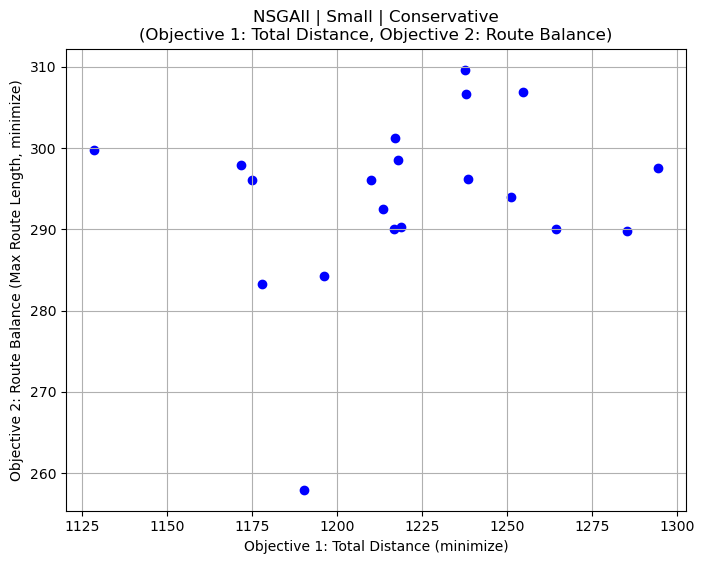

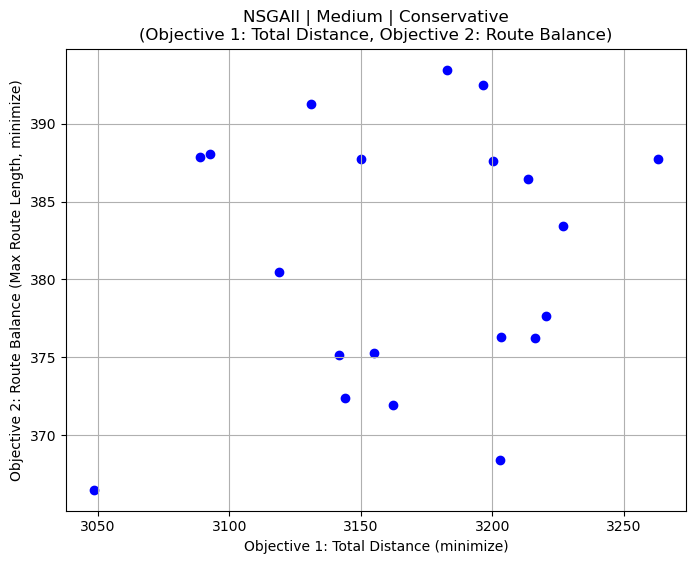

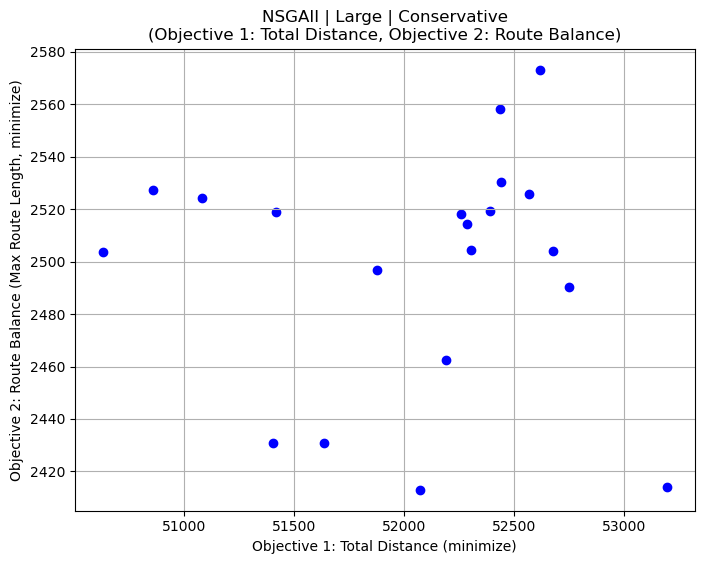

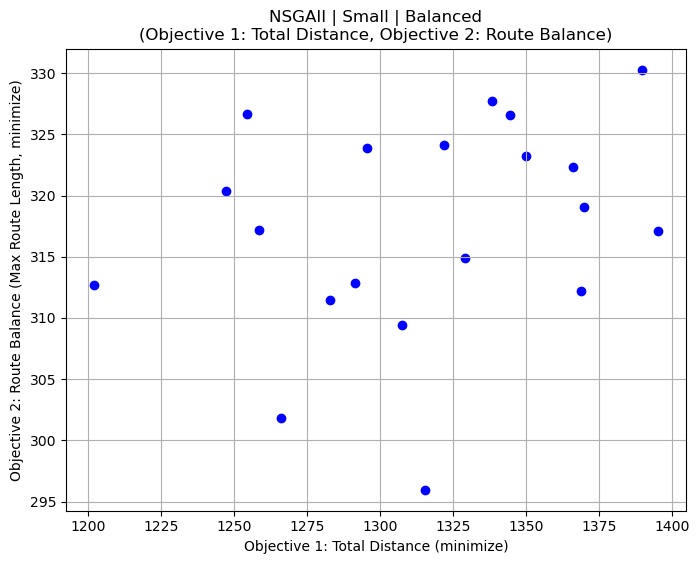

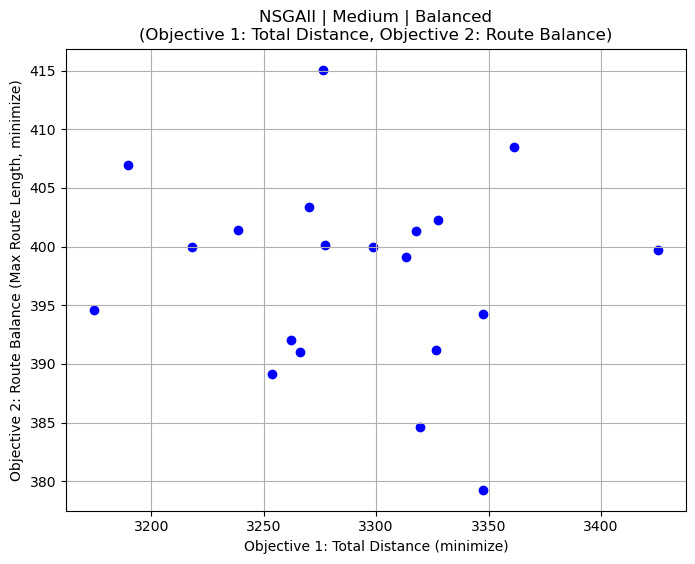

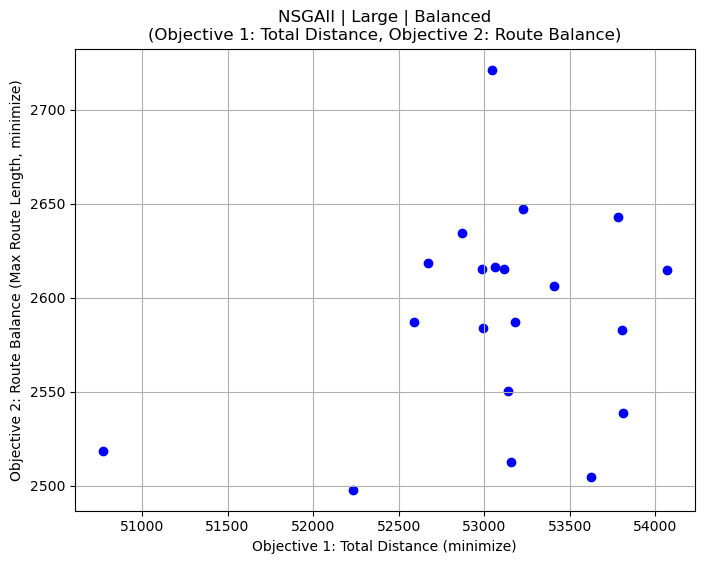

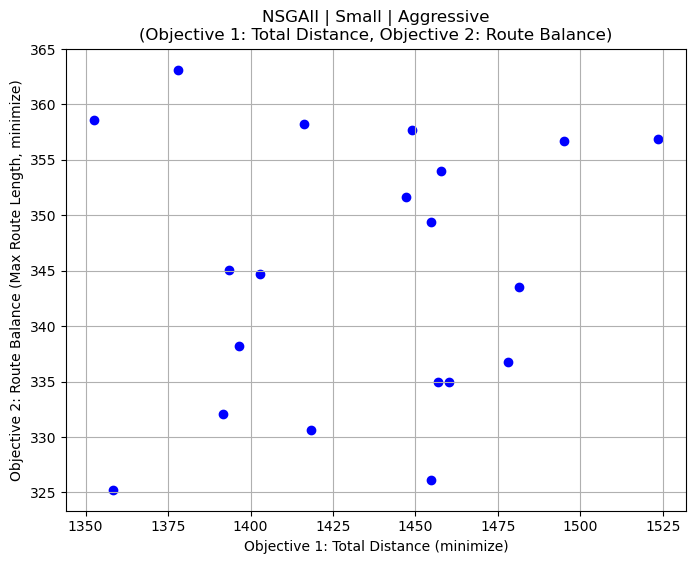

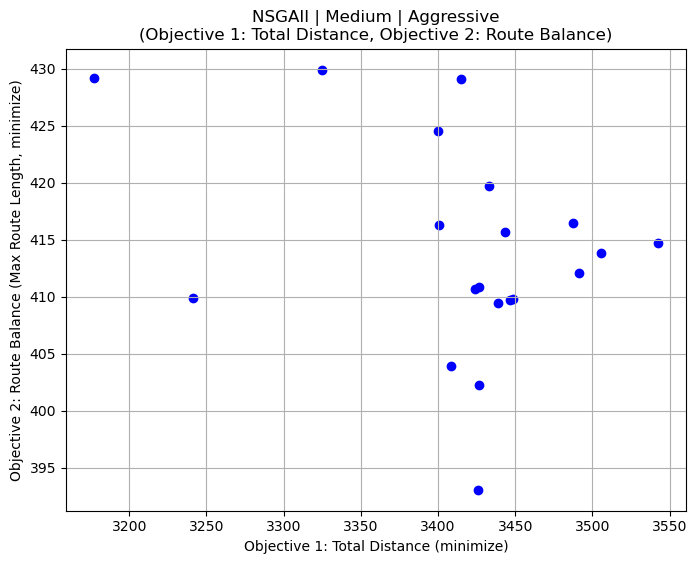

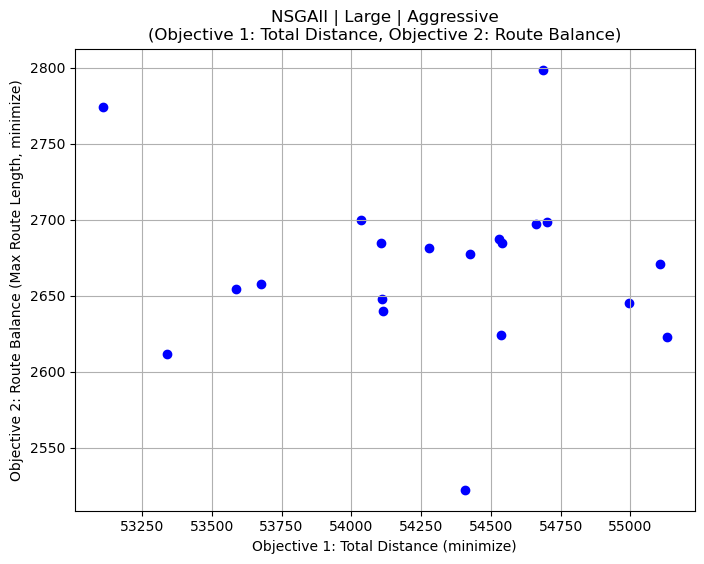

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Descriptive names for parameter sets
param_set_names = {
    1: "Conservative",
    2: "Balanced",
    3: "Aggressive"
}

def plot_final_pareto(results, instance=None, param_set=None, algo=None):
    """
    Plots the combined Pareto front from all runs for a given instance/param_set/algorithm.
    Each point is the best solution from a run (not true Pareto, but shows spread).
    """
    filtered = results
    title_parts = []
    if algo:
        filtered = [r for r in filtered if r['algorithm'] == algo]
        title_parts.append(algo)
    if instance:
        filtered = [r for r in filtered if r['instance'] == instance]
        title_parts.append(instance)
    if param_set:
        filtered = [r for r in filtered if r['param_set'] == param_set]
        param_name = param_set_names.get(param_set, f"ParamSet {param_set}")
        title_parts.append(param_name)
    title = " | ".join(title_parts) if title_parts else "All Results"
    title += "\n(Objective 1: Total Distance, Objective 2: Route Balance)"
    obj1 = [r['best_total_distance'] for r in filtered]
    obj2 = [r['best_max_route'] for r in filtered]
    plt.figure(figsize=(8,6))
    plt.scatter(obj1, obj2, c='blue')
    plt.xlabel("Objective 1: Total Distance (minimize)")
    plt.ylabel("Objective 2: Route Balance (Max Route Length, minimize)")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_dense_summary_table(df):
    """
    Prints a dense summary table for each instance and param set.
    Shows Best, Avg, Worst, Std for total distance and max route.
    Uses descriptive names for parameter sets.
    """
    print("\n=== FITNESS SCORES SUMMARY TABLE ===")
    groups = df.groupby(['instance', 'param_set'])
    header = ("Instance | ParamSet      | Best Dist | Avg Dist | Worst Dist | Std Dist | "
              "Best MaxRoute | Avg MaxRoute | Worst MaxRoute | Std MaxRoute")
    print(header)
    print("-" * len(header))
    for (instance, param_set), group in groups:
        best_dist = group['best_total_distance'].min()
        avg_dist = group['best_total_distance'].mean()
        worst_dist = group['best_total_distance'].max()
        std_dist = group['best_total_distance'].std()
        best_max = group['best_max_route'].min()
        avg_max = group['best_max_route'].mean()
        worst_max = group['best_max_route'].max()
        std_max = group['best_max_route'].std()
        param_name = param_set_names.get(param_set, str(param_set))
        print(f"{instance:7} | {param_name:13} | "
              f"{best_dist:9.2f} | {avg_dist:8.2f} | {worst_dist:10.2f} | {std_dist:8.2f} | "
              f"{best_max:13.2f} | {avg_max:12.2f} | {worst_max:13.2f} | {std_max:10.2f}")

def run_full_experiment(moea_classes, instance_files, param_sets, num_runs=20):
    """
    Runs the full experimental setup for two MOEAs, three instances, and three parameter sets.
    Records runtime, evaluations, and Pareto front statistics for each run.
    """
    results = []
    for algo_name, algo_class in moea_classes:
        for param_idx, params in enumerate(param_sets):
            print(f"\n=== {algo_name} | Param Set {param_idx+1} ({param_set_names[param_idx+1]}) ===")
            for inst_name, inst_file in instance_files:
                print(f"\n--- Instance: {inst_name} ({inst_file}) ---")
                for run in range(1, num_runs + 1):
                    print(f"Run {run}/{num_runs} (seed={run})")
                    random.seed(run)
                    np.random.seed(run)
                    data = parse_vrp_file(inst_file)
                    moea = algo_class(
                        data=data,
                        pop_size=params['pop_size'],
                        generations=params['generations'],
                        crossover_rate=params['crossover_rate'],
                        mutation_rate=params['mutation_rate']
                    )
                    start_time = time.time()
                    final_population = moea.run()
                    elapsed = time.time() - start_time
                    num_evaluations = params['pop_size'] * params['generations']

                    # Pareto front extraction
                    pareto_front = [ind for ind in final_population if ind['rank'] == 1]
                    pareto_size = len(pareto_front)
                    best_total_distance = min(ind['objectives'][0] for ind in pareto_front)
                    best_max_route = min(ind['objectives'][1] for ind in pareto_front)

                    results.append({
                        "algorithm": algo_name,
                        "param_set": param_idx+1,
                        "instance": inst_name,
                        "run": run,
                        "pareto_size": pareto_size,
                        "best_total_distance": best_total_distance,
                        "best_max_route": best_max_route,
                        "elapsed_time": elapsed,
                        "evaluations": num_evaluations
                    })
    df = pd.DataFrame(results)
    print_dense_summary_table(df)
    df.to_csv('nsga2_results.csv', index=False)
    return results

# Example usage at the bottom of your notebook:
moea_classes = [
    ("NSGAII", NSGAII),
    # ("SPEA2", SPEA2),  # Uncomment when you implement SPEA2
]
instance_files = [
    ("Small", "data/Small.vrp"),
    ("Medium", "data/Medium.vrp"),
    ("Large", "data/Large.vrp"),
]
param_sets = [
    {"pop_size": 100, "generations": 500, "crossover_rate": 0.7, "mutation_rate": 0.2},
    {"pop_size": 50, "generations": 250, "crossover_rate": 0.7, "mutation_rate": 0.2},
    {"pop_size": 30, "generations": 100, "crossover_rate": 0.7, "mutation_rate": 0.2},
]

results = run_full_experiment(moea_classes, instance_files, param_sets, num_runs=20)

# Plot Pareto front for each instance size and each parameter set
for param_set in [1, 2, 3]:
    for inst_name in ["Small", "Medium", "Large"]:
        plot_final_pareto(results, instance=inst_name, param_set=param_set, algo="NSGAII")

## SPEA2 Implementation

In [4]:
## TODO ADD ALGO